Epoch 1/30 Train Loss: 0.5846 | Val Loss: 0.3308
Epoch 2/30 Train Loss: 0.2656 | Val Loss: 0.1942
Epoch 3/30 Train Loss: 0.1785 | Val Loss: 0.1632
Epoch 4/30 Train Loss: 0.1527 | Val Loss: 0.1435
Epoch 5/30 Train Loss: 0.1353 | Val Loss: 0.1251
Epoch 6/30 Train Loss: 0.1200 | Val Loss: 0.1156
Epoch 7/30 Train Loss: 0.1123 | Val Loss: 0.1092
Epoch 8/30 Train Loss: 0.1062 | Val Loss: 0.1030
Epoch 9/30 Train Loss: 0.1011 | Val Loss: 0.0988
Epoch 10/30 Train Loss: 0.0980 | Val Loss: 0.0961
Epoch 11/30 Train Loss: 0.0952 | Val Loss: 0.0933
Epoch 12/30 Train Loss: 0.0929 | Val Loss: 0.0916
Epoch 13/30 Train Loss: 0.0913 | Val Loss: 0.0903
Epoch 14/30 Train Loss: 0.0896 | Val Loss: 0.0883
Epoch 15/30 Train Loss: 0.0880 | Val Loss: 0.0868
Epoch 16/30 Train Loss: 0.0864 | Val Loss: 0.0853
Epoch 17/30 Train Loss: 0.0846 | Val Loss: 0.0836
Epoch 18/30 Train Loss: 0.0828 | Val Loss: 0.0823
Epoch 19/30 Train Loss: 0.0813 | Val Loss: 0.0808
Epoch 20/30 Train Loss: 0.0803 | Val Loss: 0.0797
Epoch 21/

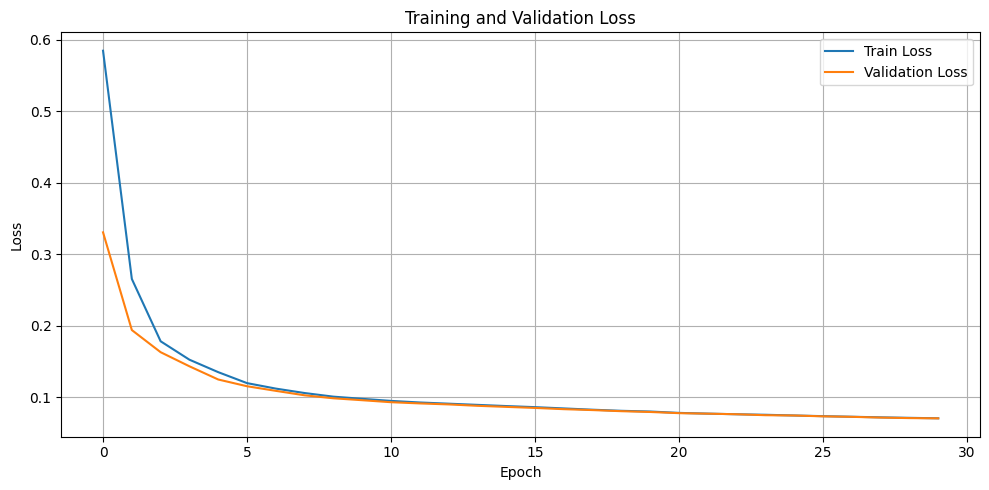

AUC Score: 0.6183


In [7]:
import os
import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# ==== ハイパーパラメータ ====
SAMPLE_RATE = 16000
N_MELS = 64
HOP_LENGTH = 512
N_FFT = 1024
BATCH_SIZE = 32
EPOCHS = 30
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ==== データセット ====
class AudioDataset(Dataset):
    def __init__(self, folder_path, is_train=True):
        self.folder_path = folder_path
        self.file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".wav")]
        self.is_train = is_train

        if not is_train:
            self.labels = [1 if "anomaly" in f.split("_")[4] else 0 for f in os.listdir(folder_path)]

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        y, sr = librosa.load(path, sr=SAMPLE_RATE)

        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT,
                                             hop_length=HOP_LENGTH, n_mels=N_MELS)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        mel_db = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-9)

        mel_tensor = torch.tensor(mel_db, dtype=torch.float32).unsqueeze(0)  # (1, N_MELS, Time)

        if self.is_train:
            return mel_tensor
        else:
            label = self.labels[idx]
            return mel_tensor, label


# ==== Autoencoder モデル ====
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(N_MELS, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, N_MELS, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x = x.squeeze(1)  # (B, 1, F, T) → (B, F, T)
        x = self.encoder(x)
        x = self.decoder(x)
        return x.unsqueeze(1)  # (B, F, T) → (B, 1, F, T)


# ==== 学習関数（train/val loss 記録 & 返却）====
def train_autoencoder(model, train_loader, val_loader):
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_losses = []
    val_losses = []

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(DEVICE)
            output = model(batch)
            loss = criterion(output, batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_batch in val_loader:
                val_batch = val_batch.to(DEVICE)
                val_output = model(val_batch)
                val_loss += criterion(val_output, val_batch).item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{EPOCHS} "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses


# ==== 評価関数（AUC算出）====
def evaluate(model, dataloader):
    model.eval()
    criterion = nn.MSELoss(reduction="none")

    scores = []
    labels = []

    with torch.no_grad():
        for batch, label in dataloader:
            batch = batch.to(DEVICE)
            output = model(batch)
            loss = criterion(output, batch)
            score = loss.mean(dim=(1, 2, 3)).cpu().numpy()
            scores.extend(score)
            labels.extend(label.numpy())

    auc = roc_auc_score(labels, scores)
    print(f"AUC Score: {auc:.4f}")


# ==== グラフ描画 ====
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


# ==== メイン処理 ====
if __name__ == "__main__":
    # データ読み込み & 分割
    full_dataset = AudioDataset("train", is_train=True)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    test_dataset = AudioDataset("test", is_train=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # モデル
    model = Autoencoder().to(DEVICE)

    # 学習
    train_losses, val_losses = train_autoencoder(model, train_loader, val_loader)

    # グラフ描画
    plot_losses(train_losses, val_losses)

    # 評価
    evaluate(model, test_loader)
